<a href="https://colab.research.google.com/github/williamF10/Generacion_de_texto_con_Transformers/blob/main/generacion_de_texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Generador de texto con transformers*

In [1]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00


In [3]:
from IPython.display import HTML

def display_df(df, max_cols=15, header= True, index =True):
  return display(HTML (df.to_html(header=header, index=index , max_cols=max_cols)))


## Greedy search decoding

El método de decodificación más sencillo para obtener tokens discretas a partir de la salida continua de un modelo es seleccionar con "avidez" la token con mayor probabilidad en cada paso de tiempo:

$$ \hat{y}_t =  \underset{y_t}{\operatorname{argmax}} P(y_t | y_{<t}, \mathbf{x}) \,.$$

Veamos cómo funciona bajo el capó con una versión española de GPT-2:

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available()else( "cpu")
model_name  = "mrm8488/spanish-gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Añadimos el token EOS como token PAD para evitar warnings
model = AutoModelForCausalLM.from_pretrained(model_name, pad_token_id = tokenizer.eos_token_id).to(device)


In [6]:
def model_size (model):
  return sum(t.numel() for t in model.parameters())

print(f"Tamaño del GPT español:{model_size(model)/1000*2:.1f}M parametros")


Tamaño del GPT español:248879.6M parametros


En cada paso de tiempo, elegimos los logits del modelo para el último token de la solicitud y los envolvemos con un softmax para obtener una distribución de probabilidad. A continuación, elegimos el siguiente token con la mayor probabilidad, lo añadimos a la secuencia de entrada y volvemos a ejecutar el proceso:



In [7]:
import pandas as pd

# Aqui es el "prompt" para continuar

input_txt = "Lo que nos ha dejado la pandemia es un camino con"

input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

iterations = []
n_steps = 12
choices_per_step = 5

with torch.no_grad():
  for _ in range (n_steps):
    iteration = dict()
    iteration ["Input"] = tokenizer.decode(input_ids[0])
    output = model(input_ids = input_ids)

   # Seleccionar los logits del primer batch y del último token y aplicar softmax
    next_token_logits = output.logits[0,-1,:]
    next_token_probs = torch.softmax(next_token_logits, dim=-1)
    sorted_ids = torch.argsort(next_token_probs, dim = -1, descending =True)

   # Almacenar las tokens con mayores probabilidades
    for choice_idx in range (choices_per_step):
      token_id = sorted_ids[choice_idx]
      token_prob = next_token_probs[token_id].cpu().numpy()
      token_choice = (
          f"{tokenizer.decode(token_id)} ({100* token_prob:.2f}%)"
      )
      iteration [f"Choice {choice_idx+1}"] = token_choice
    # Añadir el siguiente token previsto a los inputs
    input_ids = torch.cat([input_ids, sorted_ids[None, 0 , None]], dim = -1)
    iterations.append(iteration)

display_df (pd.DataFrame.from_records(iterations), index = None)

Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
Lo que nos ha dejado la pandemia es un camino con,muchos (9.00%),un (8.43%),el (6.89%),muchas (5.05%),dos (3.91%)
Lo que nos ha dejado la pandemia es un camino con muchos,obstáculos (8.00%),ba (4.98%),peligros (4.16%),problemas (4.10%),giros (3.93%)
Lo que nos ha dejado la pandemia es un camino con muchos obstáculos,. (41.91%),", (16.76%)",que (9.53%),y (8.82%),por (3.56%)
Lo que nos ha dejado la pandemia es un camino con muchos obstáculos.,La (6.55%),El (6.27%),No (5.12%),Pero (4.13%),En (4.10%)
Lo que nos ha dejado la pandemia es un camino con muchos obstáculos.La,pandemia (3.75%),enfermedad (2.55%),mayoría (2.45%),respuesta (2.13%),pobreza (2.11%)
Lo que nos ha dejado la pandemia es un camino con muchos obstáculos.La pandemia,del (20.03%),de (18.57%),es (9.28%),ha (7.06%),no (6.38%)
Lo que nos ha dejado la pandemia es un camino con muchos obstáculos.La pandemia del,VIH (55.30%),SIDA (36.49%),virus (2.38%),sida (1.70%),é (0.48%)
Lo que nos ha dejado la pandemia es un camino con muchos obstáculos.La pandemia del VIH,/ (92.98%),es (1.50%),- (0.63%),en (0.54%),se (0.49%)
Lo que nos ha dejado la pandemia es un camino con muchos obstáculos.La pandemia del VIH/,SIDA (93.44%),si (5.72%),Si (0.38%),SIDA (0.26%),IT (0.03%)
Lo que nos ha dejado la pandemia es un camino con muchos obstáculos.La pandemia del VIH/SIDA,es (22.69%),ha (11.45%),", (8.96%)",no (6.88%),se (5.01%)


Podemos obtener el mismo resultado utilizando la función `model.generate`:

In [9]:
input_ids = tokenizer (input_txt, return_tensors = "pt")["input_ids"].to(device)

output = model.generate (input_ids, max_length= 30)

print(tokenizer.decode(output[0]))

Lo que nos ha dejado la pandemia es un camino con muchos obstáculos.La pandemia del VIH/SIDA es una amenaza para la paz y la seguridad internacionales


In [11]:
max_length = 128
input_txt ="""En un hallazgo sorprendente, los científicos descubrieron una manada de unicornios \
que vivía en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. \
Más sorprendente aún para los investigadores fue el hecho de que los unicornios hablaban \
un inglés perfecto. """
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))


En un hallazgo sorprendente, los científicos descubrieron una manada de unicornios que vivía en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. Más sorprendente aún para los investigadores fue el hecho de que los unicornios hablaban un inglés perfecto. ˇEl idioma de los unicornios!ˇEl idioma de los unicornios!ˇEl idioma de los unicornios!ˇEl idioma de los unicornios!ˇEl idioma de los unicornios!ˇEl idioma de los unicornios!ˇEl idioma de los unicornios!ˇ


Hmm, hay muchas repeticiones, ¿podemos hacerlo mejor?

## Beam search

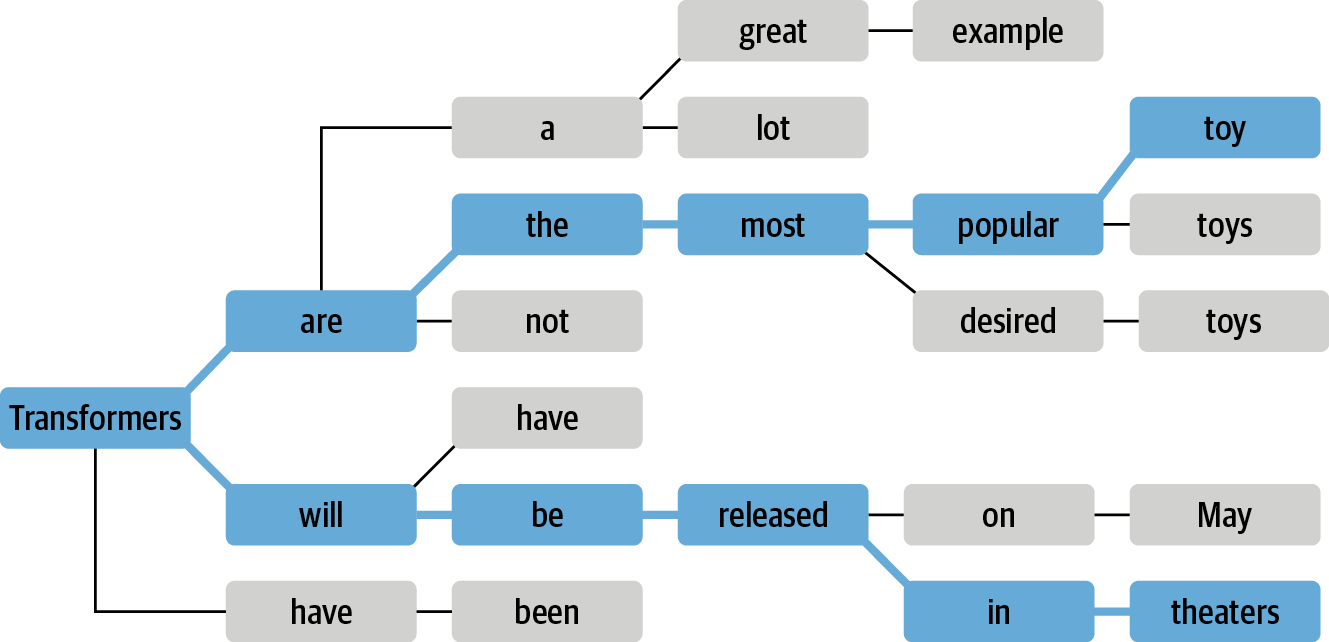

En lugar de decodificar el token con la mayor probabilidad en cada paso, beam search mantiene un registro de los próximos tokens más probables, donde $b$ se refiere al número de beams o hipótesis parciales. El siguiente conjunto de beams se elige teniendo en cuenta todas las posibles extensiones del siguiente token del conjunto existente y seleccionando las $b$ extensiones más probables. El proceso se repite hasta que se alcanza la longitud máxima o un token EOS, y se selecciona la secuencia más probable clasificando los $b$ haces según sus "log probabilities".

Calculemos y comparemos los log probabilities del texto generado por greedy search y beam search para ver si la beam search puede mejorar la probabilidad global:

In [8]:
import torch.nn.functional as F

def log_probs_from_logits(logits,labels):
  logp = F.log_softmax(logits, dim=1)
  logp_label = torch.gather(logp, 2 , labels.unsqueeze(2)).squeeze(-1)
  return logp_label



In [9]:
def sequence_logprob(model, labels, input_len = 0):
  with torch.no_grad():
    output = model(labels)
    log_probs = log_probs_from_logits(
        output.logits[:, :-1, : ], labels[:, 1:] )
    seq_log_prob = torch.sum(log_probs[:, input_len:])
  return seq_log_prob.cpu().numpy()


In [10]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"nlog-prob: {logp:.2f}")

 En un hallazgo sorprendente, los cientificos descubieron un manada de unicornios que vivian en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. Mas sorprendente aun para los investigadores fue el echo de que los unicornios hablablan un ingles perfecto. Quienes son los unicornios?Los unicornios son criaturas que viven en el aire, en el agua, en el fuego, en el agua, en el aire, en el fuego, en el agua, en el aire, en el agua, en el fuego, en el aire, en el agua, en el fuego
nlog-prob: -346.55


In [11]:
output_beam = model.generate (input_ids, max_length=max_length, num_beams=5,
                              do_sample= False)
logp = sequence_logprob(model, output_beam, input_len= len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"nlog-prob:{logp:.2f}")

 En un hallazgo sorprendente, los cientificos descubieron un manada de unicornios que vivian en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. Mas sorprendente aun para los investigadores fue el echo de que los unicornios hablablan un ingles perfecto. Quienes son los unicornios?Los unicornios son criaturas que viven en el aire, en el agua, en el fuego, en el aire, en el agua, en el fuego, en el aire, en el agua, en el fuego, en el aire, en el agua, en el aire, en el agua
nlog-prob:-346.98


In [12]:
output_beam = model.generate(input_ids, max_length = max_length, num_beams=5,
                             do_sample = False , no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len= len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"nlog-prob:{logp:.2f}")


 En un hallazgo sorprendente, los cientificos descubieron un manada de unicornios que vivian en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. Mas sorprendente aun para los investigadores fue el echo de que los unicornios hablablan un ingles perfecto. Ésta es una de las criaturas mas extrañas que he visto en mi vida.Esta es la criatura mas extraña que haya visto el hombre en su vida, y no se parece a ninguna otra criatura en el mundo.Es una criatura muy extraña, pero no es tan extraña como la que se ve en las películas de ciencia-ficción
nlog-prob:-331.75


In [13]:
torch.manual_seed(42)

output_temp = model.generate

